In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Real Beam Parameters
L_real = 2.0         # Beam length (m)
EI_real = 135245     # Flexural rigidity
q_real = 100         # UDL in N/m (uniformly distributed load)

# Normalize
L = 1.0
EI = 1.0
q = 1.0  # Normalized UDL

# Unscale factors
x_scale = L_real / L
w_scale = (q_real * L_real**4) / (EI_real * L**4)

In [2]:
# Neural Network
class PINN_Cantilever(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# Derivative function
def get_derivative(y, x, n):
    for _ in range(n):
        y = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y

# Loss Function (includes non-zero RHS)
def loss_fn(model, x_interior):
    x_interior.requires_grad = True
    w = model(x_interior)
    w_4th = get_derivative(w, x_interior, 4)
    loss_pde = torch.mean((w_4th - q / EI) ** 2)

    x0 = torch.tensor([[0.0]], requires_grad=True)
    xL = torch.tensor([[L]], requires_grad=True)

    w0 = model(x0)
    dw0 = get_derivative(w0, x0, 1)
    d2wL = get_derivative(model(xL), xL, 2)
    d3wL = get_derivative(model(xL), xL, 3)

    loss_bc = w0.pow(2) + dw0.pow(2) + d2wL.pow(2) + d3wL.pow(2)
    return loss_pde + loss_bc


Epoch 0, Loss = 0.822473
Epoch 25, Loss = 0.317342
Epoch 50, Loss = 0.181687
Epoch 75, Loss = 0.051708
Epoch 100, Loss = 0.024248
Epoch 125, Loss = 0.014535
Epoch 150, Loss = 0.009493
Epoch 175, Loss = 0.006425
Epoch 200, Loss = 0.004699
Epoch 225, Loss = 0.003762
Epoch 250, Loss = 0.003154
Epoch 275, Loss = 0.002675
Epoch 300, Loss = 0.002277
Epoch 325, Loss = 0.001941
Epoch 350, Loss = 0.001656
Epoch 375, Loss = 0.001416
Epoch 400, Loss = 0.001213
Epoch 425, Loss = 0.001042
Epoch 450, Loss = 0.000899
Epoch 475, Loss = 0.000779
Epoch 500, Loss = 0.000678
Epoch 525, Loss = 0.000593
Epoch 550, Loss = 0.000520
Epoch 575, Loss = 0.000457
Epoch 600, Loss = 0.000403
Epoch 625, Loss = 0.000355
Epoch 650, Loss = 0.000314
Epoch 675, Loss = 0.000277
Epoch 700, Loss = 0.000245
Epoch 725, Loss = 0.000217
Epoch 750, Loss = 0.000192
Epoch 775, Loss = 0.000170
Epoch 800, Loss = 0.000151
Epoch 825, Loss = 0.000135
Epoch 850, Loss = 0.000121
Epoch 875, Loss = 0.000109
Epoch 900, Loss = 0.000098
Epoch 

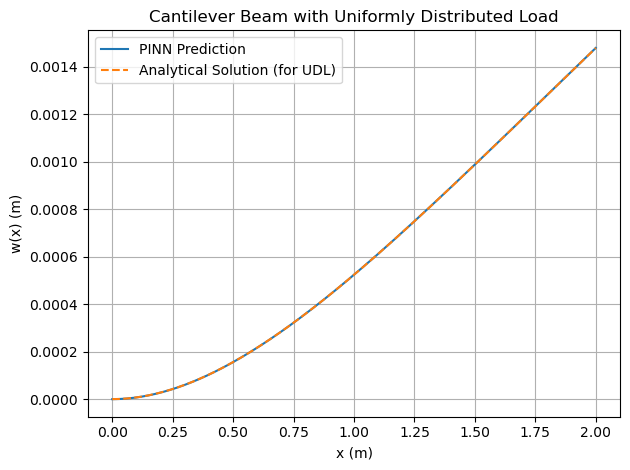

''

In [4]:
# Initialize model
model = PINN_Cantilever()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training points
x_train = torch.linspace(0, L, 50).view(-1, 1).float()

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = loss_fn(model, x_train)
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

# Evaluate
x_eval_norm = torch.linspace(0, L, 200).view(-1, 1)
x_eval_norm.requires_grad = True
w_pred_norm = model(x_eval_norm).detach().numpy()

# Unscale
x_vals = x_eval_norm.detach().numpy() * x_scale
w_pred = w_pred_norm * w_scale

# Analytical solution for UDL
w_exact = (q_real * x_vals**2 / (24 * EI_real)) * (6*L_real**2 - 4*L_real*x_vals + x_vals**2)


# Displacement
plt.figure()
plt.plot(x_vals, w_pred, label="PINN Prediction")
plt.plot(x_vals, w_exact, '--', label="Analytical Solution (for UDL)")
plt.xlabel("x (m)")
plt.ylabel("w(x) (m)")
plt.title("Cantilever Beam with Uniformly Distributed Load")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show(block = False)

input("Press Enter to exit...")  # Keeps windows open